# Machine Learning for Drug Discovery 2024
### Solubility
The code in this notebook is written to solve one of the problems from a hackathon at Machine Learning for Drug Discovery Summer School in Montreal in 2024. The benchmark is from polaris. Polaris is a hub for computational drug discovery benchmarks.

First, we import necessary packages. You might need to install polaris

**pip install polaris-lib**

In [1]:
import matplotlib.pyplot as plt
import polaris as po
import numpy as np
import datamol as dm

One of the benchmarks from the Polaris hub for the Log solubility problem containing 1578 training and 400 test points. It's a regression task. The info about this set can be found here: https://polarishub.io/benchmarks/polaris/adme-fang-solu-1

Before loading you might need to register by running the following command

**polaris login**

In [2]:
benchmark1 = po.load_benchmark("polaris/adme-fang-solu-1")

2024-07-09 18:34:48.332 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-07-09 18:34:48.408 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


We will use Datamol's `dm.to_fp` to directly featurize the inputs.

In [3]:
train, test = benchmark1.get_train_test_split(featurization_fn = dm.to_fp)
print (train.inputs[0])
print (train.targets[0])

print (train.inputs.shape)
print (train.targets.shape)

[0 0 0 ... 0 0 0]
1.567849451
(1578, 2048)
(1578,)


The Morgan fingerprints are 2048 bits long and the targets are real numbers.

Let's see if there are some columns containg only zeros, so that we can get rid of them.

In [4]:
train_features_clean = train.inputs[:,~np.all(train.inputs == 0, axis = 0)]
print (train_features_clean)
print (train_features_clean.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1578, 2048)


The size didn't change.

Now we will plot the histogram of the target values from the training set. As we can see, it is quite far from the normal distribution.

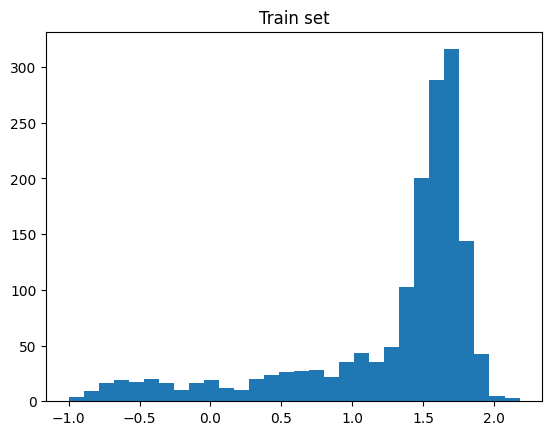

In [5]:
plt.hist(train.targets, bins=30)
plt.title("Train set")
plt.show()

Unfortunately, we cannot plot the histogram for the test set, because within Polaris you should not need to access the targets of the test set. So, we cannot transform both sets.

Below is the code for the fitting our data with the Random Forest algorithm, which returns the R2 score. It accepts two hyperparameters: the number of estimators and the max depth of trees as well as the random state.

In [6]:
from sklearn.ensemble import RandomForestRegressor

def RandomForest_r2(train, test, n_estimators, max_depth, random_state):
    model = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, random_state = random_state)
    model.fit(train.X, train.y)

    y_pred = model.predict(test.X)

    results = benchmark1.evaluate(y_pred)

    for k, item in enumerate(results.results['Metric']):
        if str(item) == 'Metric.r2':
            return results, results.results['Score'][k]
    return results, None

Here is an example for 30 estimators and max depth of 5.

In [7]:
mrf, r2_score_mrf = RandomForest_r2(train, test, 30, 5, 777)
print (30, 5, r2_score_mrf)

30 5 0.1141961436623099


It might not be the best result. Therefore, the hyperparameters need to be optimized. Below is a simple genetic algorithm for the optimization of hyperparameters of the Random Forest model.

In [8]:
def GA_for_RandomForest_r2(train, test, population_size = 16, n_steps = 10, to_print = False):
    # hyperparameters
    npop = population_size
    n_estimators_1 = 15
    n_estimators_2 = 150
    max_depth_1 = 3
    max_depth_2 = 12

    estimators_limits = (5, 200)
    depth_limits = (2, 20)

    # calculate initial score
    _, score1 = RandomForest_r2(train, test, n_estimators_1, max_depth_1, 777)
    _, score2 = RandomForest_r2(train, test, n_estimators_2, max_depth_2, 777)

    best_value = max(score1, score1)
    r2_list = list()

    if score1 > score2:
        r2_list.append((score2, max_depth_2, n_estimators_2))
        r2_list.append((score1, max_depth_1, n_estimators_1))
    else:
        r2_list.append((score1, max_depth_1, n_estimators_1))
        r2_list.append((score2, max_depth_2, n_estimators_2))

    # start the optimization
    for i in range(n_steps):
        print('iter %d. reward: %f' % (i, best_value))

        pop_estimators = generate_population(n_estimators_1, n_estimators_2, estimators_limits, npop)
        pop_depth = generate_population(max_depth_1, max_depth_2, depth_limits, npop)

        R = np.zeros(npop)
        for j in range(npop):
            _, R[j] = RandomForest_r2(train, test, pop_estimators[j], pop_depth[j], 777)
            if to_print: print (j, pop_estimators[j], pop_depth[j], R[j])

        Z = [(x, y) for _, x, y in sorted(zip(R, pop_estimators, pop_depth), key=lambda pair: pair[0])]

        n_estimators_1 = Z[-1][0]
        n_estimators_2 = Z[-2][0]

        max_depth_1 = Z[-1][1]
        max_depth_2 = Z[-2][1]

        if np.max(R) > best_value:
            best_value = np.max(R)
            r2_list.append((best_value, n_estimators_1, max_depth_1))
        else:
            n_estimators_2 = r2_list[-1][1]
            max_depth_2 = r2_list[-1][2]

    return best_value, r2_list

We need to generate a population for the genetic algorithm. We will do it based on two "parents" and also randomly apply mutations. If the parents are integers, the population will also consits of integer numbers.

In [9]:
import random

def generate_population(parent1, parent2, limits, npop):
    population = []

    for k in range(npop):
        p = random.random()
        mated_val = parent1 * p + parent2 * (1 - p)
            
        if random.random() < 0.2:
            mated_val = mated_val * (0.7 + 0.6 * random.random())
                
        if mated_val < limits[0]:
            mated_val = limits[0]
        elif mated_val > limits[1]:
            mated_val = limits[1]

        if isinstance(parent1, int) and isinstance(parent2, int):
            mated_val = int(mated_val)
                
        child = mated_val

        population.append(child)
       
    return population

Let's run GA for 10 steps.

In [10]:
best_value, r2score_list = GA_for_RandomForest_r2(train, test, to_print = False)

iter 0. reward: 0.089301
iter 1. reward: 0.168687
iter 2. reward: 0.172770
iter 3. reward: 0.174369
iter 4. reward: 0.178748
iter 5. reward: 0.183452
iter 6. reward: 0.196024
iter 7. reward: 0.196024
iter 8. reward: 0.201364
iter 9. reward: 0.203673


In [11]:
print (r2score_list[-1])

(0.212156643600252, 67, 20)


Now we rerun `RandomForest_r2` with the optimized hyperparameters.

In [12]:
mrf, r2_score_mrf = RandomForest_r2(train, test, r2score_list[-1][1], r2score_list[-1][2], 777)
print (r2score_list[-1][1], r2score_list[-1][2], r2_score_mrf)
print (mrf)

67 20 0.212156643600252
name=None description='' tags=[] user_attributes={} owner=None polaris_version='dev' results=  Test set    Target label                      Metric     Score
0     test  LOG_SOLUBILITY  Metric.mean_absolute_error  0.456667
1     test  LOG_SOLUBILITY   Metric.mean_squared_error  0.427152
2     test  LOG_SOLUBILITY                   Metric.r2  0.212157
3     test  LOG_SOLUBILITY            Metric.spearmanr  0.415035
4     test  LOG_SOLUBILITY             Metric.pearsonr  0.499596
5     test  LOG_SOLUBILITY        Metric.explained_var  0.219326 benchmark_name='adme-fang-SOLU-1' benchmark_owner=HubOwner(slug='polaris', external_id='org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu', type='organization') github_url=None paper_url=None contributors=None artifact_id=None benchmark_artifact_id='polaris/adme-fang-solu-1'


Let's now see if we can do better with the Gradient Boosting Decision Trees algorithm. Below is the code for the fitting our data with the Gradient Boosting Decision Trees algorithm, which returns the R2 score. It accepts three hyperparameters: the number of estimators, the max depth of trees and the learning rate as well as the random state.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

def GBoost_r2(train, test, n_est, max_d, learn_r, rand_st):
    model = GradientBoostingRegressor(n_estimators=n_est, max_depth=max_d, learning_rate=learn_r, random_state=rand_st)
    model.fit(train.X, train.y)

    y_pred = model.predict(test.X)

    results = benchmark1.evaluate(y_pred)

    for k, item in enumerate(results.results['Metric']):
        if str(item) == 'Metric.r2':
            return results, results.results['Score'][k]
    return results, None

Here is an example for 30 estimators, max depth of 5 and learning rate 0.12.

In [14]:
mgb, r2_score_mgb = GBoost_r2(train, test, 30, 5, 0.12, 777)
print (30, 5, 0.12, r2_score_mgb)

30 5 0.12 0.1909362514113181


Below is a simple genetic algorithm for the optimization of hyperparameters of the Gradient Boosting model.

In [15]:
def GA_for_GBoost_r2(train, test, population_size = 16, n_steps = 10, to_print = False):
    # hyperparameters
    npop = population_size
    n_estimators_1 = 15
    n_estimators_2 = 150
    max_depth_1 = 3
    max_depth_2 = 12
    learning_rate_1 = -0.6 # it will be used as an exponent
    learning_rate_2 = -1.6 # it will be used as an exponent

    estimators_limits = (5, 200)
    depth_limits = (2, 20)
    learning_rate_limits = (-2.0, 0.0)

    # calculate initial score
    _, score1 = GBoost_r2(train, test, n_estimators_1, max_depth_1, 10**learning_rate_1, 777)
    _, score2 = GBoost_r2(train, test, n_estimators_2, max_depth_2, 10**learning_rate_2, 777)

    best_value = max(score1, score1)
    r2_list = list()

    if score1 > score2:
        r2_list.append((score2, max_depth_2, n_estimators_2, learning_rate_2))
        r2_list.append((score1, max_depth_1, n_estimators_1, learning_rate_1))
    else:
        r2_list.append((score1, max_depth_1, n_estimators_1, learning_rate_1))
        r2_list.append((score2, max_depth_2, n_estimators_2, learning_rate_2))

    # start the optimization
    for i in range(n_steps):
        print('iter %d. reward: %f' % (i, best_value))

        pop_estimators = generate_population(n_estimators_1, n_estimators_2, estimators_limits, npop)
        pop_depth = generate_population(max_depth_1, max_depth_2, depth_limits, npop)
        pop_learning_rate = generate_population(learning_rate_1, learning_rate_2, learning_rate_limits, npop)

        R = np.zeros(npop)
        for j in range(npop):
            _, R[j] = GBoost_r2(train, test, pop_estimators[j], pop_depth[j], 10**pop_learning_rate[j], 777)
            if to_print: print (j, pop_estimators[j], pop_depth[j], 10**pop_learning_rate[j], R[j])

        Z = [(x, y, z) for _, x, y, z in sorted(zip(R, pop_estimators, pop_depth, pop_learning_rate), key=lambda pair: pair[0])]

        n_estimators_1 = Z[-1][0]
        n_estimators_2 = Z[-2][0]

        max_depth_1 = Z[-1][1]
        max_depth_2 = Z[-2][1]

        learning_rate_1 = Z[-1][2]
        learning_rate_2 = Z[-2][2]

        if np.max(R) > best_value:
            best_value = np.max(R)
            r2_list.append((best_value, n_estimators_1, max_depth_1, learning_rate_1))
        else:
            n_estimators_2 = r2_list[-1][1]
            max_depth_2 = r2_list[-1][2]
            learning_rate_2 = r2_list[-1][3]

    return best_value, r2_list

Let's run GA for 10 steps.

In [16]:
best_value, r2score_list = GA_for_GBoost_r2(train, test)

iter 0. reward: 0.138732
iter 1. reward: 0.227278
iter 2. reward: 0.249996
iter 3. reward: 0.249996
iter 4. reward: 0.249996
iter 5. reward: 0.259216
iter 6. reward: 0.265759
iter 7. reward: 0.280829
iter 8. reward: 0.281360
iter 9. reward: 0.281360


In [17]:
print (r2score_list[-1])

(0.28171813674985613, 138, 8, -0.9990261044933678)


Now we rerun `GBoost_r2` with the optimized hyperparameters.

In [18]:
rgb, r2_score_rgb = GBoost_r2(train, test, r2score_list[-1][1], r2score_list[-1][2], 10**r2score_list[-1][3], 777)
print (r2score_list[-1][1], r2score_list[-1][2], 10**r2score_list[-1][3], r2_score_rgb)
print (rgb)

138 8 0.10022449935083845 0.28171813674985613
name=None description='' tags=[] user_attributes={} owner=None polaris_version='dev' results=  Test set    Target label                      Metric     Score
0     test  LOG_SOLUBILITY  Metric.mean_absolute_error  0.437920
1     test  LOG_SOLUBILITY   Metric.mean_squared_error  0.389437
2     test  LOG_SOLUBILITY                   Metric.r2  0.281718
3     test  LOG_SOLUBILITY            Metric.spearmanr  0.491951
4     test  LOG_SOLUBILITY             Metric.pearsonr  0.538332
5     test  LOG_SOLUBILITY        Metric.explained_var  0.285496 benchmark_name='adme-fang-SOLU-1' benchmark_owner=HubOwner(slug='polaris', external_id='org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu', type='organization') github_url=None paper_url=None contributors=None artifact_id=None benchmark_artifact_id='polaris/adme-fang-solu-1'


## Conclusion

The best results for the **Gradient Boosting Decision Trees** algorithm and Morgan fingerprints, **R2 = 0.281718**, are obtained with the following hyperparameters: n_estimators = 138, max_depth = 8, learning_rate = 0.10022449935083845.

The best results for the **Random Forest** algorithm and Morgan fingerprints, **R2 = 0.212157**, are obtained with the following hyperparameters: n_estimators = 67, max_depth = 20.

So, the Gradient Boosting Decision Trees algorithm is noticeably better than Random Forest.

In the next Jypyter notebooks we will explore the performance of other descriptors with the Gradient Boosting Decision Trees algorithm.